In [1]:
using Pkg;
Pkg.activate("../");

using PyCall;
pygui(:tk);

  Activating project at `d:\GitHub\book-dp1`


In [2]:
"""
Firm valuation with exit option.

"""

using QuantEcon, LinearAlgebra
include("s_approx.jl")

"Creates an instance of the firm exit model."
function create_exit_model(;
        n=200,                  # productivity grid size
        ρ=0.95, μ=0.1, ν=0.1,   # persistence, mean and volatility
        β=0.98, s=100.0         # discount factor and scrap value
    )
    mc = tauchen(n, ρ, ν, μ)
    z_vals, Q = mc.state_values, mc.p
    return (; n, z_vals, Q, β, s)
end


"Compute value of firm without exit option."
function no_exit_value(model)
    (; n, z_vals, Q, β, s) = model
    return (I - β * Q) \ z_vals
end

" The Bellman operator Tv = max{s, π + β Q v}."
function T(v, model)
    (; n, z_vals, Q, β, s) = model
    h = z_vals .+ β * Q * v
    return max.(s, h)
end

" Get a v-greedy policy."
function get_greedy(v, model)
    (; n, z_vals, Q, β, s) = model
    σ = s .>= z_vals .+ β * Q * v
    return σ
end

"Solve by VFI."
function vfi(model) 
    v_init = no_exit_value(model)
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16


function plot_val(; savefig=false, 
                     figname="../figures/firm_exit_1.pdf")

    fig, ax = plt.subplots(figsize=(9, 5.2))

    model = create_exit_model()
    (; n, z_vals, Q, β, s) = model

    v_star, σ_star = vfi(model)
    h = z_vals + β * Q * v_star

    ax.plot(z_vals, h, "-", lw=3, alpha=0.6, label=L"h^*")
    ax.plot(z_vals, s * ones(n), "-", lw=3, alpha=0.6, label=L"s")
    ax.plot(z_vals, v_star, "k--", lw=1.5, alpha=0.8, label=L"v^*")

    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"z", fontsize=fontsize)

    if savefig
        fig.savefig(figname)
    end
end


function plot_comparison(; savefig=false, 
                     figname="../figures/firm_exit_2.pdf")

    fig, ax = plt.subplots(figsize=(9, 5.2))

    model = create_exit_model()
    (; n, z_vals, Q, β, s) = model

    v_star, σ_star = vfi(model)
    w = no_exit_value(model)

    ax.plot(z_vals, v_star, "k-", lw=2, alpha=0.6, label=L"v^*")
    ax.plot(z_vals, w, lw=2, alpha=0.6, label="no-exit value")

    ax.legend(frameon=false, fontsize=fontsize)
    ax.set_xlabel(L"z", fontsize=fontsize)

    if savefig
        fig.savefig(figname)
    end
end



plot_comparison (generic function with 1 method)

Completed iteration 25 with error 0.03580715900042719.
Completed iteration 50 with error 0.017225068626771645.
Completed iteration 75 with error 0.00676835562268252.
Completed iteration 100 with error 0.002642877005840205.
Completed iteration 125 with error 0.001043441654843491.
Completed iteration 150 with error 0.0004139022964579908.
Completed iteration 175 with error 0.00016428959624192885.
Completed iteration 200 with error 6.521647846113865e-5.
Completed iteration 225 with error 2.5888622744218992e-5.
Completed iteration 250 with error 1.027687515886555e-5.
Completed iteration 275 with error 4.079559587921722e-6.
Completed iteration 300 with error 1.6194423579918293e-6.
Terminated successfully in 315 iterations.

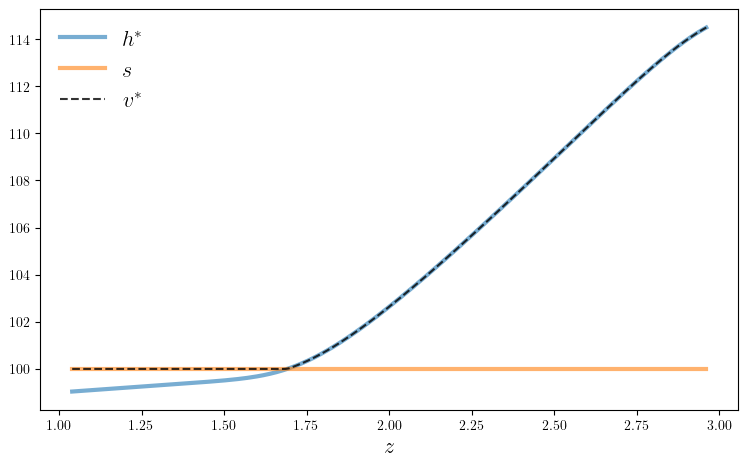

In [3]:
plot_val(savefig=true)

Completed iteration 25 with error 0.03580715900042719.
Completed iteration 50 with error 0.017225068626771645.
Completed iteration 75 with error 0.00676835562268252.
Completed iteration 100 with error 0.002642877005840205.
Completed iteration 125 with error 0.001043441654843491.
Completed iteration 150 with error 0.0004139022964579908.
Completed iteration 175 with error 0.00016428959624192885.
Completed iteration 200 with error 6.521647846113865e-5.
Completed iteration 225 with error 2.5888622744218992e-5.
Completed iteration 250 with error 1.027687515886555e-5.
Completed iteration 275 with error 4.079559587921722e-6.
Completed iteration 300 with error 1.6194423579918293e-6.
Terminated successfully in 315 iterations.

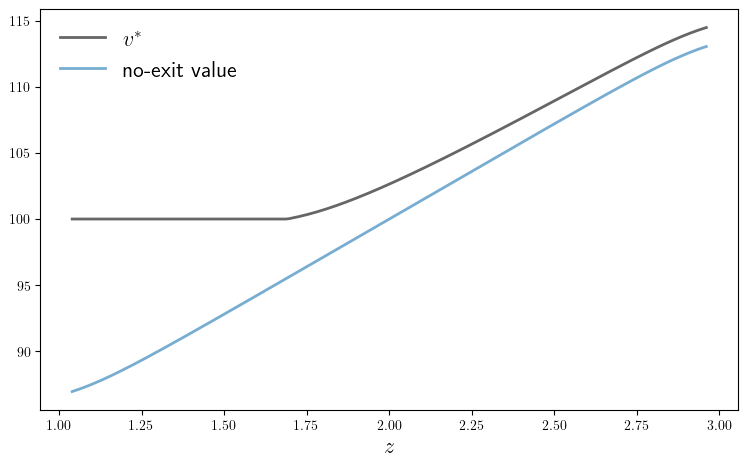

In [4]:
plot_comparison(savefig=true)

In [5]:
"""
Valuation for finite-horizon American call options in discrete time.

"""

include("s_approx.jl")
using QuantEcon, LinearAlgebra, IterTools

"Creates an instance of the option model with log S_t = Z_t + W_t."
function create_american_option_model(;
        n=100, μ=10.0,  # Markov state grid size and mean value
        ρ=0.98, ν=0.2,  # persistence and volatility for Markov state
        s=0.3,          # volatility parameter for W_t
        r=0.01,         # interest rate 
        K=10.0, T=200)  # strike price and expiration date
    t_vals = collect(1:T+1)
    mc = tauchen(n, ρ, ν)
    z_vals, Q = mc.state_values .+ μ, mc.p
    w_vals, φ, β = [-s, s], [0.5, 0.5], 1 / (1 + r)
    e(t, i_w, i_z) = (t ≤ T) * (z_vals[i_z] + w_vals[i_w] - K)
    return (; t_vals, z_vals, w_vals, Q, φ, T, β, K, e)
end

"The continuation value operator."
function C(h, model)
    (; t_vals, z_vals, w_vals, Q, φ, T, β, K, e) = model
    Ch = similar(h)
    z_idx, w_idx = eachindex(z_vals), eachindex(w_vals)
    for (t, i_z) in product(t_vals, z_idx)
        out = 0.0
        for (i_w′, i_z′) in product(w_idx, z_idx)
            t′ = min(t + 1, T + 1)
            out += max(e(t′, i_w′, i_z′), h[t′, i_z′]) * 
                       Q[i_z, i_z′] * φ[i_w′]
        end
        Ch[t, i_z] = β * out
    end
    return Ch
end

"Compute the continuation value function by successive approx."
function compute_cvf(model) 
    h_init = zeros(length(model.t_vals), length(model.z_vals))
    h_star = successive_approx(h -> C(h, model), h_init)
    return h_star
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16


function plot_contours(; savefig=false, 
                         figname="../figures/american_option_1.pdf")

    model = create_american_option_model()
    (; t_vals, z_vals, w_vals, Q, φ, T, β, K, e) = model
    h_star = compute_cvf(model)

    fig, axes = plt.subplots(3, 1, figsize=(7, 11))
    z_idx, w_idx = eachindex(z_vals), eachindex(w_vals)
    H = zeros(length(w_vals), length(z_vals))

    for (ax_index, t) in zip(1:3, (1, 195, 199))

        ax = axes[ax_index, 1]

        for (i_w, i_z) in product(w_idx, z_idx)
            H[i_w, i_z] = e(t, i_w, i_z) - h_star[t, i_z]
        end

        cs1 = ax.contourf(w_vals, z_vals, transpose(H), alpha=0.5)
        ctr1 = ax.contour(w_vals, z_vals, transpose(H), levels=[0.0])
        plt.clabel(ctr1, inline=1, fontsize=13)
        plt.colorbar(cs1, ax=ax) #, format="%.6f")

        ax.set_title(L"t=" * "$t", fontsize=fontsize)
        ax.set_xlabel(L"w", fontsize=fontsize)
        ax.set_ylabel(L"z", fontsize=fontsize)

    end

    fig.tight_layout()
    if savefig
        fig.savefig(figname)
    end
end


function plot_strike(; savefig=false, 
                       fontsize=12,
                       figname="../figures/american_option_2.pdf")

    model = create_american_option_model()
    (; t_vals, z_vals, w_vals, Q, φ, T, β, K, e) = model
    h_star = compute_cvf(model)

    # Built Markov chains for simulation 
    z_mc = MarkovChain(Q, z_vals)
    P_φ = zeros(length(w_vals), length(w_vals))
    for i in eachindex(w_vals)  # Build IID chain
        P_φ[i, :] = φ
    end
    w_mc = MarkovChain(P_φ, w_vals)


    y_min = minimum(z_vals) + minimum(w_vals)
    y_max = maximum(z_vals) + maximum(w_vals)
    fig, axes = plt.subplots(3, 1, figsize=(7, 12))

    for ax in axes

        # Generate price series
        z_draws = simulate_indices(z_mc, T, init=Int(length(z_vals) / 2 - 10))
        w_draws = simulate_indices(w_mc, T)
        s_vals = z_vals[z_draws] + w_vals[w_draws]

        # Find the exercise date, if any.
        exercise_date = T + 1
        for t in 1:T
            if e(t, w_draws[t], z_draws[t]) ≥ h_star[w_draws[t], z_draws[t]]
                exercise_date = t
            end
        end

        @assert exercise_date ≤ T "Option not exercised."

        # Plot
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(1, T)
        ax.fill_between(1:T, ones(T) * K, ones(T) * y_max, alpha=0.2)
        ax.plot(1:T, s_vals, label=L"S_t")
        ax.plot((exercise_date,), (s_vals[exercise_date]), "ko")
        ax.vlines((exercise_date,), 0, (s_vals[exercise_date]), ls="--", colors="black")
        ax.legend(loc="upper left", fontsize=fontsize)
        ax.text(-10, 11, "in the money", fontsize=fontsize, rotation=90)
        ax.text(-10, 7.2, "out of the money", fontsize=fontsize, rotation=90)
        ax.text(exercise_date-20, 6, #s_vals[exercise_date]+0.8, 
                "exercise date", fontsize=fontsize)
        ax.set_xticks((1, T))
        ax.set_yticks((y_min, y_max))
    end

    if savefig
        fig.savefig(figname)
    end
end

plot_strike (generic function with 1 method)

Completed iteration 25 with error 0.006681671219211427.


Completed iteration 50 with error 0.0039970038843408495.


Completed iteration 75 with error 0.002922808660469428.


Completed iteration 100 with error 0.0019603799011774503.


Completed iteration 125 with error 0.0012415595933039647.


Completed iteration 150 with error 0.00077388789719951.


Completed iteration 175 with error 0.000481112768765779.


Completed iteration 200 with error 0.0.
Terminated successfully in 201 iterations.


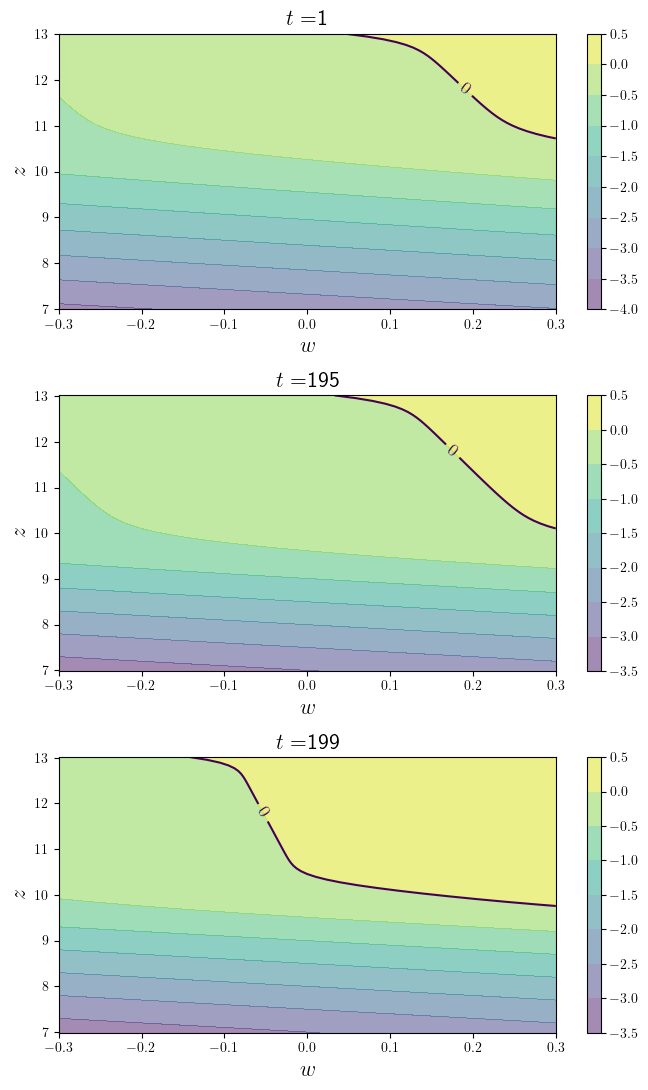

In [6]:
plot_contours(savefig=true)

Completed iteration 25 with error 0.006681671219211427.


Completed iteration 50 with error 0.0039970038843408495.


Completed iteration 75 with error 0.002922808660469428.


Completed iteration 100 with error 0.0019603799011774503.


Completed iteration 125 with error 0.0012415595933039647.


Completed iteration 150 with error 0.00077388789719951.


Completed iteration 175 with error 0.000481112768765779.


Completed iteration 200 with error 0.0.
Terminated successfully in 201 iterations.


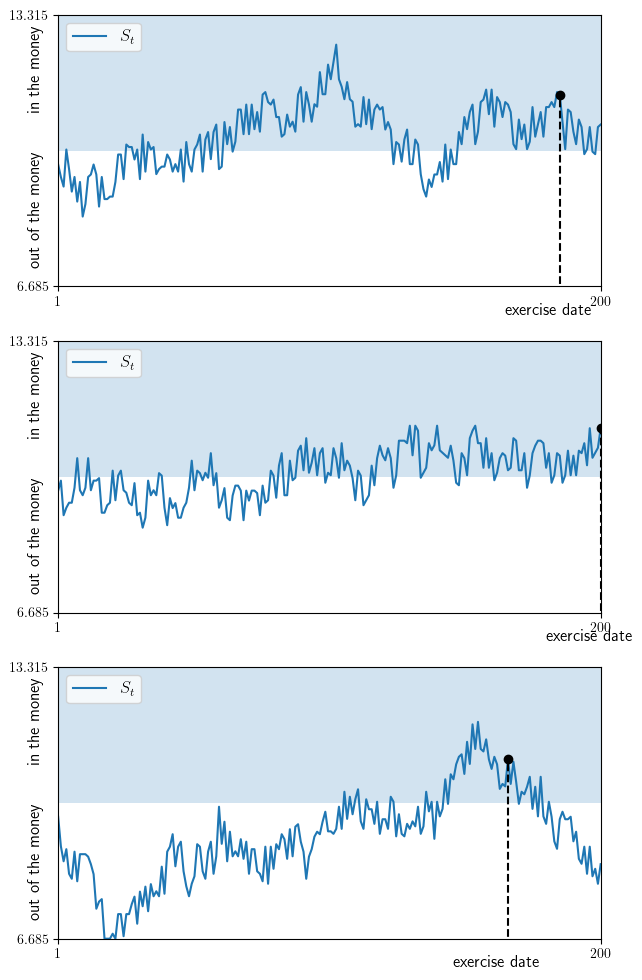

In [7]:
plot_strike(savefig=true)